# Progam to analyse SNP files from Illumina analysis
The program proceeds the analysis of SNP files resulting from Illumina sequentiation. Major aspect of the program is the usage of the PLINK library to perform binary conversion of the input data.

                 0    1    2    3    4    5    6    7    8    9    ... 147  \
208006009302531    0    0    0    0    0    0    0    0    0    0  ...   0   
276000116648174    1    1    1    1    1    1    1    1    1    1  ...   1   
276000114554758    2    2    2    2    2    2    2    2    2    2  ...   0   
276000116039433    3    3    3    3    3    3    3    3    3    3  ...   2   
276000111909505    4    4    4    4    4    4    4    4    4    4  ...   3   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..   
276000108612636  152  151  150  149  148  147  147  146  145  144  ...   3   
276000121491989  153  152  151  150  149  148  148  147  146  145  ...   2   
276000112528404  154  153  152  151  150  149  149  148  147  146  ...   0   
276000114048185  155  154  153  152  151  150  101  101  101  101  ...   3   
276000121333235  156  155  154  153  152  151  150  149  148  147  ...   6   

                148 149 150 151 152 153 154 155 156  
208006009

<Figure size 432x288 with 0 Axes>

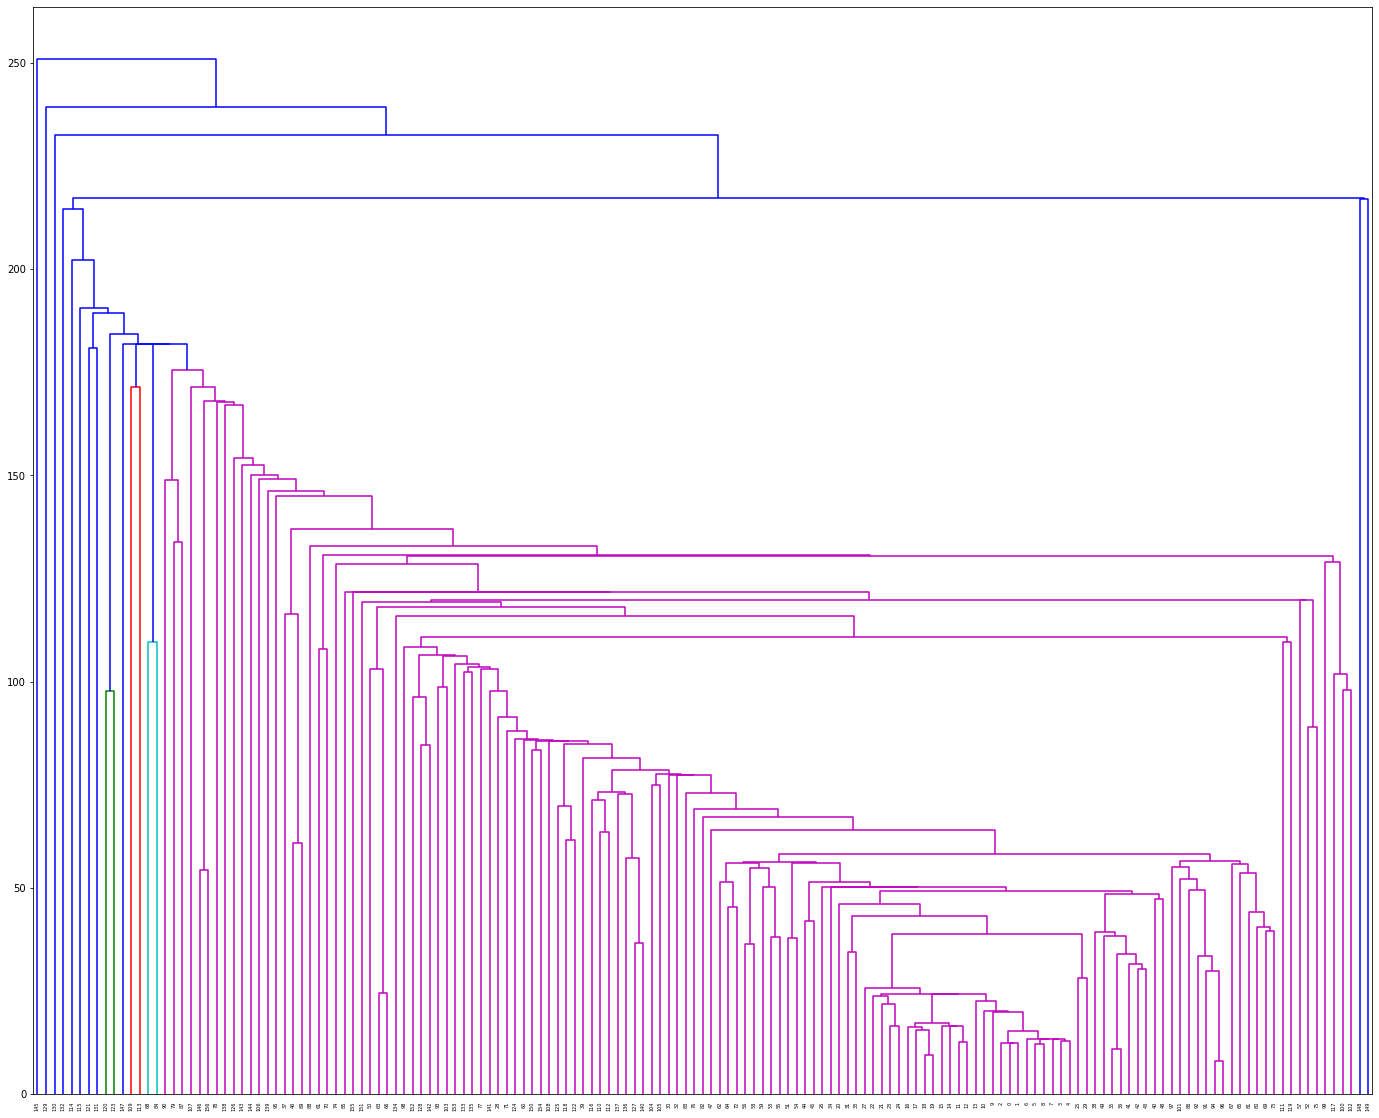

In [1]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import subprocess
import zipfile
import os
import itertools
from scipy.cluster import hierarchy
from matplotlib import pyplot as plt


class SNP_Processing():
    def __init__(self, folder=None):
        self.folder = folder
        if "/home/users" in os.environ["HOME"]:
            # this condition filters, whether the script is executed on a server without 
            # the user having root rights, such as at the servers of Universität Kassel
            # solution from:
            # https://stackoverflow.com/questions/4906977/how-do-i-access-environment-variables-from-python/4907053#4907053
            self.plink = "~/Programme/plink-1.07-x86_64/plink"
        else:
            self.plink = "plink"
    
    def zip_handling(self, l):
        for f in l:
            if os.path.isdir(l):
                continue
            elif "zip" in f:
                with zipfile.ZipFile(l, "r") as zip_ref:
                    folder_name = l.split(".")[0:-1]
                    # the original file name is shortened by the .zip
                    zip_ref.extractall(folder_name[0])
                    os.remove(f)
                    yield self.folder + folder_name[0]
                    # the new path is returned, to allow processing in 
                    # following functions
    
    def req_files(self):
        try:
            return os.listdir(self.folder)
        except FileNotFoundError:
            print("Folder not found")
            return None

    def processing(self, method):
        files = self.req_files()
        for path in self.zip_handling(files):
            # the path involved includes the file name already
            # which is the base to the new folder to create the 
            # binary files
            raw_files = os.listdir(path)
            # the raw files in the unzipped directory are 
            # listed
            for plinkfile in raw_files:
                if ".ped" in plinkfile:
                    pedfile = path + "/" + plinkfile
                if ".map" in plinkfile:
                    mapfile = path + "/" + plinkfile
            make_bed = subprocess.run(
                [
                    self.plink, 
                    # calls plink
                    "--ped", 
                    # maps the pedigree file to the 
                    # processing
                    pedfile, 
                    # path to the pedigree file
                    "--map", 
                    # maps the map file to the processing
                    mapfile, 
                    # path to the map file
                    "--make-bed", 
                    "--out", 
                    # maps the output
                    path + "/" + "hapmap1", 
                    # path to the output files
                    "--cow", 
                    # ensures, the designated organism
                    # has 60 chromosomes
                    "--noweb"
                    # suppresses web connections
                ]
            )
            return self.further_processing(path, method)
            
    def further_processing(self, path, method, fname=None):
        if fname is None:
            fname = "hapmap1"
            # this is the filename used in the plink calls of the former function
            # therefore, it can safely be used to name a file for further processing
            if fname not in os.listdir(path):
                # checks if the file exists in the folder
                # and terminates the program, in case the file does not 
                # exist
                print("Filename not found in directory " + path)
                return None
        if "association" in method:
            assoc = subprocess.run(
                [
                    self.plink, 
                    "--bfile", 
                    path + "/" + fname, 
                    "--maf",
                    # minor allel frequency, 
                    # mainly caused by errors in genotyping process
                    str(0.05),
                    "--hwe",
                    # Hardy-Weinberg equilibrium, measurement for 
                    # the reading frequency and genetic drift of allels in a population
                    str(10e-6),
                    "--assoc", 
                    "--out",
                    path + "/" + "as1",
                    "--noweb"
                    # always make sure to set the --noweb option, otherwise
                    # the calculation might be executed on another machine
                ]
            )
            return self.convert_to_readable(path, "as1", "assoc", method) 
        elif "cluster" in method:
            cluster = subprocess.run(
                [
                    self.plink,
                    "--bfile",
                    path + "/" + fname,
                    "--maf",
                    # minor allel frequency, 
                    # mainly caused by errors in genotyping process
                    str(0.05),
                    "--hwe",
                    # Hardy-Weinberg equilibrium, measurement for 
                    # the reading frequency and genetic drift of allels in a population
                    str(10e-6),
                    "--cluster",
                    "--out",
                    path + "/" + "cls",
                    "--noweb"
                ]
            )
            #if "cluster3" in os.listdir(path):
            #    return self.convert_to_readable(path, "cls", "cluster3", method)
        else:
            print(f"The viable option are 'association' and 'cluster'. \n You have chosen {method}")
            # this type of formatting has been introduced with python 3.6,
            # please refer to:
            # https://www.linode.com/docs/development/python/string-manipulation-python-3/#f-strings
            return None
        
    def convert_to_readable(self, path, file, extension, method):
        try:
            with open(path + "/" + file + "." + extension, "r", encoding="utf-8") as input_file:
                return self.process_plink_res(input_file, method)
        except FileNotFoundError:
            r = self.further_processing(path, method)
            with open(path + "/" + file + "." + extension, "r", encoding="utf-8") as _input_file:
                return self.process_plink_res(_input_file, method)
            
    def process_plink_res(self, input_file, method):
        r = []
        i = []
        if "cluster" in method:
            # this is the descrption of the files
            # http://zzz.bwh.harvard.edu/plink/strat.shtml
            for l in input_file:
                l = l.split(" ")
                l = [s.split("\t")[0:] for s in l]
                l = [i for si in l for i in si]
                # please refer the solution to:
                # https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python/952952#952952
                try:
                    i.append(l[1])
                # the number of the individual is taken as the index
                except IndexError:
                    continue
                r.append(np.array(l[2:-1]))
            return pd.DataFrame(index=i, data=r)
        elif "association" in method:
            for l in input_file:
                l = list(filter(None, l.split(" ")))[:-1]
                # kindly refer this syntax to:
                # https://stackoverflow.com/questions/3845423/remove-empty-strings-from-a-list-of-strings/3845453#3845453
                i.append(l[0])
                r.append(l[1:])
            df = pd.DataFrame(index=i[1:], data=r[1:], columns=r[0])
            return df.replace("NA", np.NaN)
        else:
            return None
    
    
    def plot_relations(self, path=None, file=None, calc_cluster=False):
        if calc_cluster is True and path is None and file is None:
            _input = self.processing(method="cluster")
        elif calc_cluster is False and path is not None and file is not None:
            # in this case, the cluster calculation has already been performed and 
            # only the plotting is executed, in this case, file refers to the 
            # prefix of the cluster files
            _input = self.convert_to_readable(
                path=path, 
                file=file, 
                extension="cluster3",
                # this is the cluster file organized as a dendrogram
                method="cluster"
            )
            print(_input)
        elif calc_cluster is True and path is not None and file is not None:
            # in this case the cluster has to be calculated in the first step
            # the file refers to the binary plink files
            _input = self.further_processing(
                path=path, 
                fname=file,
                method="cluster"
            )
        else:
            print("Please specify the path or input method")
            return None
        # following code refers to:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
        Z = hierarchy.linkage(_input.values, "single")
        plt.figure()
        fig, ax = plt.subplots(1, sharex="all", sharey="all", figsize=(24,20))
        dn1 = hierarchy.dendrogram(Z, ax=ax, orientation="top", above_threshold_color="b")
        hierarchy.set_link_color_palette(None)
        plt.xticks()
        #plt.savefig("Test.pgf", format="pgf")
        # save the figure, before showing it!!!
        plt.show()
        
#SNP_Processing("/home/thomas/Dokumente/Uni/Mitarbeiterstelle Witzenhausen/SNP-Daten").binary_processing()
#SNP_Processing().further_processing(
#    "/home/thomas/Dokumente/Uni/Mitarbeiterstelle Witzenhausen/SNP-Daten/Alte Angler männlich",
#    "assoc", 
#    "RVAml_few"
#)
#SNP_Processing().convert_to_readable(
#    "/home/thomas/Dokumente/Uni/Mitarbeiterstelle Witzenhausen/SNP-Daten/Alte Angler männlich", 
#    "cls", 
#    "cluster3",
#    "cluster"
#)
SNP_Processing().plot_relations(
    path="/home/thomas/Dokumente/Uni/Mitarbeiterstelle Witzenhausen/SNP-Daten/Alte Angler männlich", 
    file="cls"
)
